In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime 
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from statsmodels.tsa.arima.model import ARIMA
import itertools
import statsmodels.tsa.api as tsa

In [2]:
#Download the prices
ticker = '^GSPC'
start = datetime.datetime(2015, 1, 1)
end = datetime.datetime(2021, 1, 1)
SP_prices = yf.download(ticker, start=start, end=end, interval='1mo').Close


[*********************100%***********************]  1 of 1 completed


In [3]:
sample = SP_prices.resample('M').last()

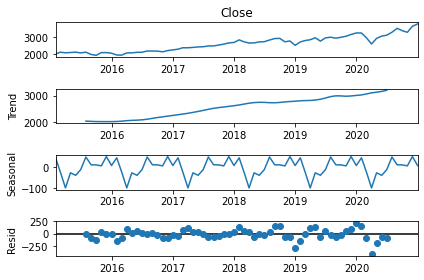

In [4]:
seasonal_decompose(sample, period=12, model="additive").plot()
plt.show()

c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


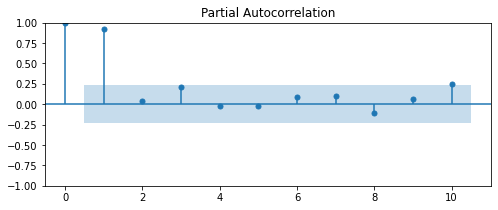

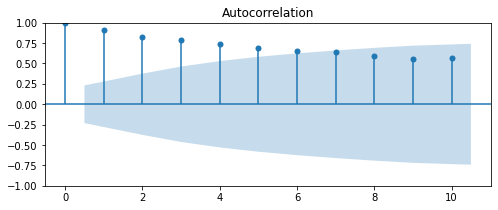

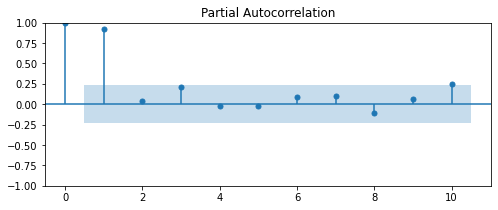

In [5]:
fig, ax = plt.subplots(figsize=(8,3))
plot_acf(sample, ax=ax, lags=10)

fig, ax = plt.subplots(figsize=(8,3))
plot_pacf(sample, ax=ax, lags=10)

In [6]:
def adf_test(x):
    indices = ['Test Statistic', 'p-value',
'   # of Lags Used', '# of Observations Used']
    adf_test = adfuller(x, autolag='AIC')
    results = pd.Series(adf_test[0:4], index=indices)
    for key, value in adf_test[4].items():
        results[f'Critical Value ({key})'] = value
    
        return results
    
adf_test(sample)

Test Statistic             0.030295
p-value                    0.960967
   # of Lags Used          0.000000
# of Observations Used    71.000000
Critical Value (1%)       -3.526005
dtype: float64

The null hypothesis of the ADF test states that the time series is not stationary.
With a p-value of 0.99 (or equivalently, the test statistic larger than the critical value for the selected confidence level), we have no reason to reject the null hypothesis, meaning that we can conclude that the series is not stationary

Take the first difference to make it stationary

<AxesSubplot:title={'center':'First Differences'}, xlabel='Date'>

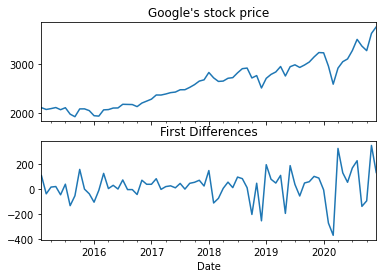

In [7]:
sample_diff = SP_prices.diff().dropna()
fig, ax = plt.subplots(2, sharex=True)
SP_prices.plot(title = "Google's stock price", ax=ax[0])
sample_diff.plot(ax=ax[1], title='First Differences')

In [8]:
def adf_test(x):
    indices = ['Test Statistic', 'p-value',
'   # of Lags Used', '# of Observations Used']
    adf_test = adfuller(x, autolag='AIC')
    results = pd.Series(adf_test[0:4], index=indices)
    for key, value in adf_test[4].items():
        results[f'Critical Value ({key})'] = value
    
        return results
    
adf_test(sample_diff)

Test Statistic           -7.095106e+00
p-value                   4.309555e-10
   # of Lags Used         1.000000e+00
# of Observations Used    6.900000e+01
Critical Value (1%)      -3.528890e+00
dtype: float64

Check if it has been deseasoned and detrended

In [9]:
# seasonal_decompose(sample_diff, period=12).plot()
# plt.show()

Get the p,q values since our d=1 using ACF and PACF

In [10]:
# acf_plot = plot_acf(sample_diff, lags = 10)
# acf_plot = plot_pacf(sample_diff, lags = 10)

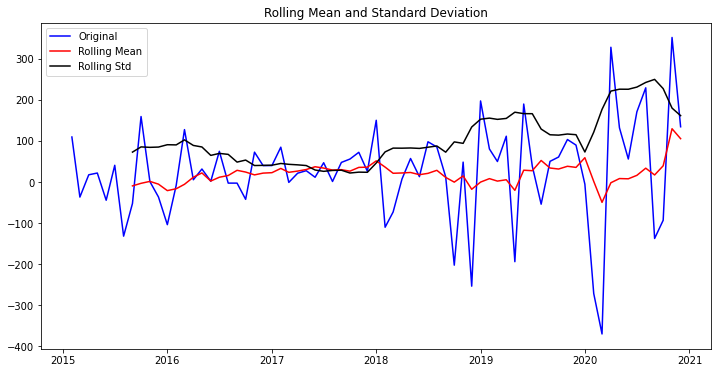

Results of Dickey-Fuller Test:
Test Statistics               -7.095106e+00
p-value                        4.309555e-10
Number of observations used    1.000000e+00
Critical Value (1%)           -3.528890e+00
Critical Value (5%)           -2.904440e+00
Critical Value (10%)          -2.589656e+00
dtype: float64


In [11]:
roll_mean = sample_diff.rolling(window=8, center=False).mean()
roll_std = sample_diff.rolling(window=8, center=False).std()

df_test = adfuller(sample_diff)

fig = plt.figure(figsize=(12,6))
orig = plt.plot(sample_diff, color='blue', label='Original')
mean=plt.plot(roll_mean, color='red', label='Rolling Mean')
std=plt.plot(roll_std, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean and Standard Deviation')
plt.show(block=False)

print('Results of Dickey-Fuller Test:')

dfoutput = pd.Series(df_test[0:3], index=['Test Statistics', 'p-value', #Lags Used],
                                          'Number of observations used'])
for key, value in df_test[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


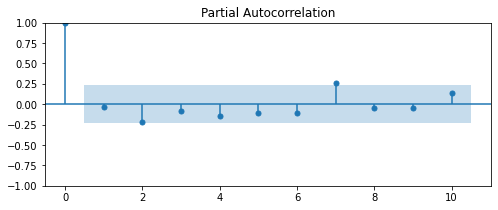

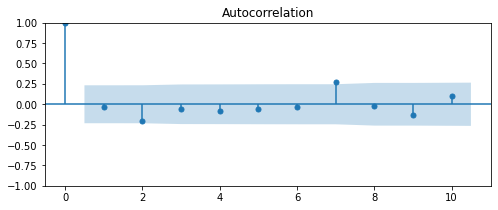

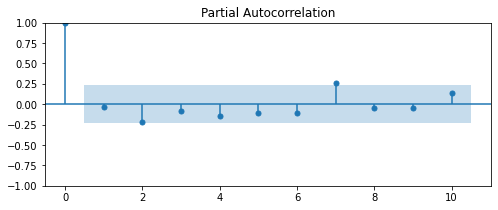

In [12]:
fig, ax = plt.subplots(figsize=(8,3))
plot_acf(sample_diff, ax=ax, lags=10)

fig, ax = plt.subplots(figsize=(8,3))
plot_pacf(sample_diff, ax=ax, lags=10)

In [13]:
p = d =q = range(0,3)

pdq = list(itertools.product(p,d,q))

pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p,d,q))]
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(sample,
                                        order=comb,
                                        seasonal_order=combs,
                                        enforce_stationarity = False,
                                        enforce_invertibility=False)
            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated = {}'.format(comb, combs, output.aic))
    
        except:
            continue

ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].astype(float)]


ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 1321.8783045864134
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 1040.0889415183904


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 0, 0) x (0, 0, 2, 12)12 : AIC Calculated = 805.3779890559185
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 846.1049541318635
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 678.0002543577002


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 0, 0) x (0, 1, 2, 12)12 : AIC Calculated = 493.2376203316097
ARIMA (0, 0, 0) x (0, 2, 0, 12)12 : AIC Calculated = 678.3350385883136


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (0, 0, 0) x (0, 2, 1, 12)12 : AIC Calculated = 1601.3125526481865


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 0, 0) x (0, 2, 2, 12)12 : AIC Calculated = 314.20312220356726
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 810.7575799782497
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 786.4163111317584


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (0, 0, 0) x (1, 0, 2, 12)12 : AIC Calculated = 631.4102234185457
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 686.7229080129048
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 653.5258950625184


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 0, 0) x (1, 1, 2, 12)12 : AIC Calculated = 494.12164519373573
ARIMA (0, 0, 0) x (1, 2, 0, 12)12 : AIC Calculated = 506.01730477312134


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (0, 0, 0) x (1, 2, 1, 12)12 : AIC Calculated = 1321.6239700495728


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 0, 0) x (1, 2, 2, 12)12 : AIC Calculated = 316.1217655261631
ARIMA (0, 0, 0) x (2, 0, 0, 12)12 : AIC Calculated = 642.6717683609032
ARIMA (0, 0, 0) x (2, 0, 1, 12)12 : AIC Calculated = 642.6508830950448


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (0, 0, 0) x (2, 0, 2, 12)12 : AIC Calculated = 631.4808643329962
ARIMA (0, 0, 0) x (2, 1, 0, 12)12 : AIC Calculated = 506.45380184783
ARIMA (0, 0, 0) x (2, 1, 1, 12)12 : AIC Calculated = 496.70753986034026


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 0, 0) x (2, 1, 2, 12)12 : AIC Calculated = 482.74145003988764
ARIMA (0, 0, 0) x (2, 2, 0, 12)12 : AIC Calculated = 331.44261790325504


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (0, 0, 0) x (2, 2, 1, 12)12 : AIC Calculated = 927.9024117169082


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 0, 0) x (2, 2, 2, 12)12 : AIC Calculated = 318.0541380162873
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 1213.503735041758
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 953.5702585859609


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 0, 1) x (0, 0, 2, 12)12 : AIC Calculated = 738.2181570765258
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 786.5429930555283
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 630.23600755121


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 0, 1) x (0, 1, 2, 12)12 : AIC Calculated = 463.7819315904192
ARIMA (0, 0, 1) x (0, 2, 0, 12)12 : AIC Calculated = 639.5347502243997


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 0, 1) x (0, 2, 1, 12)12 : AIC Calculated = 1379.6304938635901
ARIMA (0, 0, 1) x (0, 2, 2, 12)12 : AIC Calculated = 298.30025584277047


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 814.3730853069824


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 743.92043011848


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (0, 0, 1) x (1, 0, 2, 12)12 : AIC Calculated = 597.8431309208033
ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 657.5344646769568
ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 615.4991581963942


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 0, 1) x (1, 1, 2, 12)12 : AIC Calculated = 457.6100616999287
ARIMA (0, 0, 1) x (1, 2, 0, 12)12 : AIC Calculated = 490.31225984581835


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (0, 0, 1) x (1, 2, 1, 12)12 : AIC Calculated = 1288.1469579254817


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 0, 1) x (1, 2, 2, 12)12 : AIC Calculated = 299.9725612504467
ARIMA (0, 0, 1) x (2, 0, 0, 12)12 : AIC Calculated = 621.2690730099941


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 0, 1) x (2, 0, 1, 12)12 : AIC Calculated = 622.0862186612683


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (0, 0, 1) x (2, 0, 2, 12)12 : AIC Calculated = 600.016865671311
ARIMA (0, 0, 1) x (2, 1, 0, 12)12 : AIC Calculated = 490.86318181227216
ARIMA (0, 0, 1) x (2, 1, 1, 12)12 : AIC Calculated = 484.21980144589276


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 0, 1) x (2, 1, 2, 12)12 : AIC Calculated = 457.53583876150196
ARIMA (0, 0, 1) x (2, 2, 0, 12)12 : AIC Calculated = 325.28612853981497


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 0, 1) x (2, 2, 1, 12)12 : AIC Calculated = 975.8646600165081
ARIMA (0, 0, 1) x (2, 2, 2, 12)12 : AIC Calculated = 301.9250730404425
ARIMA (0, 0, 2) x (0, 0, 0, 12)12 : AIC Calculated = 1120.7093386902375
ARIMA (0, 0, 2) x (0, 0, 1, 12)12 : AIC Calculated = 887.7188563607144


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 0, 2) x (0, 0, 2, 12)12 : AIC Calculated = 693.1901927536122
ARIMA (0, 0, 2) x (0, 1, 0, 12)12 : AIC Calculated = 757.903261310458
ARIMA (0, 0, 2) x (0, 1, 1, 12)12 : AIC Calculated = 607.3767946442551


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 0, 2) x (0, 1, 2, 12)12 : AIC Calculated = 447.39945495991435
ARIMA (0, 0, 2) x (0, 2, 0, 12)12 : AIC Calculated = 624.9554279220101
ARIMA (0, 0, 2) x (0, 2, 1, 12)12 : AIC Calculated = 1360.6978464613353


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 0, 2) x (0, 2, 2, 12)12 : AIC Calculated = 286.57394977495505


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (0, 0, 2) x (1, 0, 0, 12)12 : AIC Calculated = 778.625853858324


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 0, 2) x (1, 0, 1, 12)12 : AIC Calculated = 736.069691780225


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (0, 0, 2) x (1, 0, 2, 12)12 : AIC Calculated = 581.9444386039048
ARIMA (0, 0, 2) x (1, 1, 0, 12)12 : AIC Calculated = 646.7591037445401
ARIMA (0, 0, 2) x (1, 1, 1, 12)12 : AIC Calculated = 600.2644801839841


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 0, 2) x (1, 1, 2, 12)12 : AIC Calculated = 441.52448423660735
ARIMA (0, 0, 2) x (1, 2, 0, 12)12 : AIC Calculated = 487.94283346392797


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (0, 0, 2) x (1, 2, 1, 12)12 : AIC Calculated = 1346.7222494733714


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 0, 2) x (1, 2, 2, 12)12 : AIC Calculated = 288.03543176919277


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (0, 0, 2) x (2, 0, 0, 12)12 : AIC Calculated = 616.5445189319014


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 0, 2) x (2, 0, 1, 12)12 : AIC Calculated = 688.9424976950202


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (0, 0, 2) x (2, 0, 2, 12)12 : AIC Calculated = 660.3832890296426
ARIMA (0, 0, 2) x (2, 1, 0, 12)12 : AIC Calculated = 488.0877049191936
ARIMA (0, 0, 2) x (2, 1, 1, 12)12 : AIC Calculated = 482.6963727342828


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (0, 0, 2) x (2, 1, 2, 12)12 : AIC Calculated = 442.68395896280754
ARIMA (0, 0, 2) x (2, 2, 0, 12)12 : AIC Calculated = 325.5324638215012


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (0, 0, 2) x (2, 2, 1, 12)12 : AIC Calculated = 977.8876714385133


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 0, 2) x (2, 2, 2, 12)12 : AIC Calculated = 290.0069932827022
ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 873.0120651564245
ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 732.9406145521205


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 1, 0) x (0, 0, 2, 12)12 : AIC Calculated = 590.9324334401355
ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 755.0232158272539
ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 594.4486196737508


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 1, 0) x (0, 1, 2, 12)12 : AIC Calculated = 444.96919487731725
ARIMA (0, 1, 0) x (0, 2, 0, 12)12 : AIC Calculated = 645.749133917035


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 1, 0) x (0, 2, 1, 12)12 : AIC Calculated = 1469.5834488461603
ARIMA (0, 1, 0) x (0, 2, 2, 12)12 : AIC Calculated = 302.7544922651561
ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 744.4225557990518
ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 734.776744952764


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 1, 0) x (1, 0, 2, 12)12 : AIC Calculated = 592.9316040883929
ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 601.823436013377
ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 590.9872139166758


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 1, 0) x (1, 1, 2, 12)12 : AIC Calculated = 446.82332893275884
ARIMA (0, 1, 0) x (1, 2, 0, 12)12 : AIC Calculated = 469.61803200133636


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 1, 0) x (1, 2, 1, 12)12 : AIC Calculated = 1245.9943623704062
ARIMA (0, 1, 0) x (1, 2, 2, 12)12 : AIC Calculated = 302.2303155542967
ARIMA (0, 1, 0) x (2, 0, 0, 12)12 : AIC Calculated = 601.6576864754176
ARIMA (0, 1, 0) x (2, 0, 1, 12)12 : AIC Calculated = 603.5607764567724


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 1, 0) x (2, 0, 2, 12)12 : AIC Calculated = 593.6774506693886
ARIMA (0, 1, 0) x (2, 1, 0, 12)12 : AIC Calculated = 458.0343997314045


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 1, 0) x (2, 1, 1, 12)12 : AIC Calculated = 460.1349208630773
ARIMA (0, 1, 0) x (2, 1, 2, 12)12 : AIC Calculated = 448.75065070296455
ARIMA (0, 1, 0) x (2, 2, 0, 12)12 : AIC Calculated = 313.9665497219178


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 1, 0) x (2, 2, 1, 12)12 : AIC Calculated = 991.0824987900148
ARIMA (0, 1, 0) x (2, 2, 2, 12)12 : AIC Calculated = 304.13885855244877
ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 863.4697060571153
ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 722.398934497356


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 1, 1) x (0, 0, 2, 12)12 : AIC Calculated = 581.361987367128
ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 743.6989880377068
ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 583.9236326610998


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated = 434.04594642751744
ARIMA (0, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated = 633.4013283328063


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 1, 1) x (0, 2, 1, 12)12 : AIC Calculated = 1594.9579980169233
ARIMA (0, 1, 1) x (0, 2, 2, 12)12 : AIC Calculated = 292.3041389762754
ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 746.4213429034023
ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 724.3197626894964


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 1, 1) x (1, 0, 2, 12)12 : AIC Calculated = 583.3619596425924
ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 603.6486650942383
ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 581.1150968620881


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated = 435.9612775750079
ARIMA (0, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated = 471.1684344744004


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 1, 1) x (1, 2, 1, 12)12 : AIC Calculated = 1609.3789192741685
ARIMA (0, 1, 1) x (1, 2, 2, 12)12 : AIC Calculated = 291.26828882923166
ARIMA (0, 1, 1) x (2, 0, 0, 12)12 : AIC Calculated = 603.6013297672073
ARIMA (0, 1, 1) x (2, 0, 1, 12)12 : AIC Calculated = 605.5269932537427


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 1, 1) x (2, 0, 2, 12)12 : AIC Calculated = 583.9476157283642
ARIMA (0, 1, 1) x (2, 1, 0, 12)12 : AIC Calculated = 460.0106514450331
ARIMA (0, 1, 1) x (2, 1, 1, 12)12 : AIC Calculated = 461.8633336623841


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 1, 1) x (2, 1, 2, 12)12 : AIC Calculated = 437.86386135323505
ARIMA (0, 1, 1) x (2, 2, 0, 12)12 : AIC Calculated = 315.493305192609


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 1, 1) x (2, 2, 1, 12)12 : AIC Calculated = 1123.7145714520263
ARIMA (0, 1, 1) x (2, 2, 2, 12)12 : AIC Calculated = 293.2907046884756
ARIMA (0, 1, 2) x (0, 0, 0, 12)12 : AIC Calculated = 851.2994734788756
ARIMA (0, 1, 2) x (0, 0, 1, 12)12 : AIC Calculated = 710.9260870380142


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 1, 2) x (0, 0, 2, 12)12 : AIC Calculated = 570.5431725754819
ARIMA (0, 1, 2) x (0, 1, 0, 12)12 : AIC Calculated = 726.3869691192036
ARIMA (0, 1, 2) x (0, 1, 1, 12)12 : AIC Calculated = 570.7447447894987


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 1, 2) x (0, 1, 2, 12)12 : AIC Calculated = 423.6992367598112
ARIMA (0, 1, 2) x (0, 2, 0, 12)12 : AIC Calculated = 616.8544196971498


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 1, 2) x (0, 2, 1, 12)12 : AIC Calculated = 1224.2923658677673
ARIMA (0, 1, 2) x (0, 2, 2, 12)12 : AIC Calculated = 276.70266041314574
ARIMA (0, 1, 2) x (1, 0, 0, 12)12 : AIC Calculated = 746.2435831305075
ARIMA (0, 1, 2) x (1, 0, 1, 12)12 : AIC Calculated = 712.8804847553231


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 1, 2) x (1, 0, 2, 12)12 : AIC Calculated = 572.2207101347815
ARIMA (0, 1, 2) x (1, 1, 0, 12)12 : AIC Calculated = 604.7745521103658
ARIMA (0, 1, 2) x (1, 1, 1, 12)12 : AIC Calculated = 570.1290992316442


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 1, 2) x (1, 1, 2, 12)12 : AIC Calculated = 425.6068873555741
ARIMA (0, 1, 2) x (1, 2, 0, 12)12 : AIC Calculated = 472.6001428998152


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 1, 2) x (1, 2, 1, 12)12 : AIC Calculated = 1244.303896020855


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (0, 1, 2) x (1, 2, 2, 12)12 : AIC Calculated = 278.6863849593268
ARIMA (0, 1, 2) x (2, 0, 0, 12)12 : AIC Calculated = 604.5499481942397
ARIMA (0, 1, 2) x (2, 0, 1, 12)12 : AIC Calculated = 606.4121087133027


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 1, 2) x (2, 0, 2, 12)12 : AIC Calculated = 573.2744317548302
ARIMA (0, 1, 2) x (2, 1, 0, 12)12 : AIC Calculated = 461.25258060568734
ARIMA (0, 1, 2) x (2, 1, 1, 12)12 : AIC Calculated = 462.872995009337


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 1, 2) x (2, 1, 2, 12)12 : AIC Calculated = 427.6065320672137
ARIMA (0, 1, 2) x (2, 2, 0, 12)12 : AIC Calculated = 317.43329808385323


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (0, 1, 2) x (2, 2, 1, 12)12 : AIC Calculated = 853.0788078669906


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (0, 1, 2) x (2, 2, 2, 12)12 : AIC Calculated = 280.6673218977781
ARIMA (0, 2, 0) x (0, 0, 0, 12)12 : AIC Calculated = 908.370778976092
ARIMA (0, 2, 0) x (0, 0, 1, 12)12 : AIC Calculated = 759.0701078211185


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 2, 0) x (0, 0, 2, 12)12 : AIC Calculated = 607.9233160423779
ARIMA (0, 2, 0) x (0, 1, 0, 12)12 : AIC Calculated = 779.0646681271622
ARIMA (0, 2, 0) x (0, 1, 1, 12)12 : AIC Calculated = 611.2013647549325


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 2, 0) x (0, 1, 2, 12)12 : AIC Calculated = 451.8137205878463
ARIMA (0, 2, 0) x (0, 2, 0, 12)12 : AIC Calculated = 660.7799768621887


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 2, 0) x (0, 2, 1, 12)12 : AIC Calculated = 1661.3452324456127
ARIMA (0, 2, 0) x (0, 2, 2, 12)12 : AIC Calculated = 303.9427688139596
ARIMA (0, 2, 0) x (1, 0, 0, 12)12 : AIC Calculated = 771.9015289942118
ARIMA (0, 2, 0) x (1, 0, 1, 12)12 : AIC Calculated = 761.0275541515396


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 2, 0) x (1, 0, 2, 12)12 : AIC Calculated = 609.972926254654
ARIMA (0, 2, 0) x (1, 1, 0, 12)12 : AIC Calculated = 616.8767015864693
ARIMA (0, 2, 0) x (1, 1, 1, 12)12 : AIC Calculated = 606.5131383836896


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 2, 0) x (1, 1, 2, 12)12 : AIC Calculated = 452.1566908664662
ARIMA (0, 2, 0) x (1, 2, 0, 12)12 : AIC Calculated = 474.7335628249063


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 2, 0) x (1, 2, 1, 12)12 : AIC Calculated = 1149.1392886386495
ARIMA (0, 2, 0) x (1, 2, 2, 12)12 : AIC Calculated = 298.74384822964333
ARIMA (0, 2, 0) x (2, 0, 0, 12)12 : AIC Calculated = 618.0476738461974
ARIMA (0, 2, 0) x (2, 0, 1, 12)12 : AIC Calculated = 619.9596106543949


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 2, 0) x (2, 0, 2, 12)12 : AIC Calculated = 608.0318458359241
ARIMA (0, 2, 0) x (2, 1, 0, 12)12 : AIC Calculated = 463.906901027721
ARIMA (0, 2, 0) x (2, 1, 1, 12)12 : AIC Calculated = 465.53198066300087


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 2, 0) x (2, 1, 2, 12)12 : AIC Calculated = 453.1853440559489
ARIMA (0, 2, 0) x (2, 2, 0, 12)12 : AIC Calculated = 308.73228843875006


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (0, 2, 0) x (2, 2, 1, 12)12 : AIC Calculated = 785.1742957387441


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 2, 0) x (2, 2, 2, 12)12 : AIC Calculated = 298.4196802597217
ARIMA (0, 2, 1) x (0, 0, 0, 12)12 : AIC Calculated = 852.4223799622398
ARIMA (0, 2, 1) x (0, 0, 1, 12)12 : AIC Calculated = 710.6303160691768


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 2, 1) x (0, 0, 2, 12)12 : AIC Calculated = 570.1280677246298
ARIMA (0, 2, 1) x (0, 1, 0, 12)12 : AIC Calculated = 734.7708729665956
ARIMA (0, 2, 1) x (0, 1, 1, 12)12 : AIC Calculated = 574.6951766598039


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 2, 1) x (0, 1, 2, 12)12 : AIC Calculated = 424.70461444501586
ARIMA (0, 2, 1) x (0, 2, 0, 12)12 : AIC Calculated = 623.1986258785505


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (0, 2, 1) x (0, 2, 1, 12)12 : AIC Calculated = 1433.4509825594466


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 2, 1) x (0, 2, 2, 12)12 : AIC Calculated = 280.58258180959035
ARIMA (0, 2, 1) x (1, 0, 0, 12)12 : AIC Calculated = 734.2957606451622
ARIMA (0, 2, 1) x (1, 0, 1, 12)12 : AIC Calculated = 712.2107474253378


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 2, 1) x (1, 0, 2, 12)12 : AIC Calculated = 571.679274668178
ARIMA (0, 2, 1) x (1, 1, 0, 12)12 : AIC Calculated = 595.3145945790855
ARIMA (0, 2, 1) x (1, 1, 1, 12)12 : AIC Calculated = 572.1841748872027


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 2, 1) x (1, 1, 2, 12)12 : AIC Calculated = 424.5740532408488
ARIMA (0, 2, 1) x (1, 2, 0, 12)12 : AIC Calculated = 461.52452270975846


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (0, 2, 1) x (1, 2, 1, 12)12 : AIC Calculated = 1358.1852574846948


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 2, 1) x (1, 2, 2, 12)12 : AIC Calculated = 279.84627874174487
ARIMA (0, 2, 1) x (2, 0, 0, 12)12 : AIC Calculated = 593.7879705860446
ARIMA (0, 2, 1) x (2, 0, 1, 12)12 : AIC Calculated = 595.7511423434083


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 2, 1) x (2, 0, 2, 12)12 : AIC Calculated = 572.882244155924
ARIMA (0, 2, 1) x (2, 1, 0, 12)12 : AIC Calculated = 448.8636350960988
ARIMA (0, 2, 1) x (2, 1, 1, 12)12 : AIC Calculated = 450.6966381767227


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 2, 1) x (2, 1, 2, 12)12 : AIC Calculated = 426.5737846260817
ARIMA (0, 2, 1) x (2, 2, 0, 12)12 : AIC Calculated = 304.567472637969


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (0, 2, 1) x (2, 2, 1, 12)12 : AIC Calculated = 811.9153369526532


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (0, 2, 1) x (2, 2, 2, 12)12 : AIC Calculated = 281.9408491832782
ARIMA (0, 2, 2) x (0, 0, 0, 12)12 : AIC Calculated = 842.9708200917236
ARIMA (0, 2, 2) x (0, 0, 1, 12)12 : AIC Calculated = 700.9528724599766


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 2, 2) x (0, 0, 2, 12)12 : AIC Calculated = 560.4835989193709
ARIMA (0, 2, 2) x (0, 1, 0, 12)12 : AIC Calculated = 724.1738612119165
ARIMA (0, 2, 2) x (0, 1, 1, 12)12 : AIC Calculated = 564.1378840814281


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 2, 2) x (0, 1, 2, 12)12 : AIC Calculated = 414.4831444889963
ARIMA (0, 2, 2) x (0, 2, 0, 12)12 : AIC Calculated = 611.7197892806671


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 2, 2) x (0, 2, 1, 12)12 : AIC Calculated = 1304.4085321793216
ARIMA (0, 2, 2) x (0, 2, 2, 12)12 : AIC Calculated = 269.6117165602782
ARIMA (0, 2, 2) x (1, 0, 0, 12)12 : AIC Calculated = 735.8801624795736
ARIMA (0, 2, 2) x (1, 0, 1, 12)12 : AIC Calculated = 702.2381497952855


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 2, 2) x (1, 0, 2, 12)12 : AIC Calculated = 561.924610214743
ARIMA (0, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated = 597.0532278932069
ARIMA (0, 2, 2) x (1, 1, 1, 12)12 : AIC Calculated = 562.0505848587352


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated = 414.63047864846743
ARIMA (0, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated = 463.2916933308738


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 2, 2) x (1, 2, 1, 12)12 : AIC Calculated = 1181.76918794506
ARIMA (0, 2, 2) x (1, 2, 2, 12)12 : AIC Calculated = 267.97543954895986
ARIMA (0, 2, 2) x (2, 0, 0, 12)12 : AIC Calculated = 595.7870139920889
ARIMA (0, 2, 2) x (2, 0, 1, 12)12 : AIC Calculated = 597.7509328593404


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 2, 2) x (2, 0, 2, 12)12 : AIC Calculated = 563.1653106223545
ARIMA (0, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated = 450.56348004780824
ARIMA (0, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated = 452.5236244178467


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated = 416.63047625184646
ARIMA (0, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated = 306.4409234291903


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (0, 2, 2) x (2, 2, 1, 12)12 : AIC Calculated = 728.9616993028635


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (0, 2, 2) x (2, 2, 2, 12)12 : AIC Calculated = 269.9207581870845
ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 884.3162647673227


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 743.0852088776579


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 0, 0) x (0, 0, 2, 12)12 : AIC Calculated = 603.0330350105402
ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 766.7497420185157
ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 608.3088164798996


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 0, 0) x (0, 1, 2, 12)12 : AIC Calculated = 459.53848360929663
ARIMA (1, 0, 0) x (0, 2, 0, 12)12 : AIC Calculated = 652.3390110044954
ARIMA (1, 0, 0) x (0, 2, 1, 12)12 : AIC Calculated = 1440.6795341252744


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 0, 0) x (0, 2, 2, 12)12 : AIC Calculated = 312.3222824847591
ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 764.3117471868869
ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 752.8846804106705


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (1, 0, 0) x (1, 0, 2, 12)12 : AIC Calculated = 604.7400672517484
ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 603.7945905063285
ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 603.827524894893


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 0, 0) x (1, 1, 2, 12)12 : AIC Calculated = 461.4207167930334
ARIMA (1, 0, 0) x (1, 2, 0, 12)12 : AIC Calculated = 468.0147490295917


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 0, 0) x (1, 2, 1, 12)12 : AIC Calculated = 1245.3341479361309
ARIMA (1, 0, 0) x (1, 2, 2, 12)12 : AIC Calculated = 314.7989460076949
ARIMA (1, 0, 0) x (2, 0, 0, 12)12 : AIC Calculated = 603.3927029774578
ARIMA (1, 0, 0) x (2, 0, 1, 12)12 : AIC Calculated = 603.275795067213


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (1, 0, 0) x (2, 0, 2, 12)12 : AIC Calculated = 606.7866864997305
ARIMA (1, 0, 0) x (2, 1, 0, 12)12 : AIC Calculated = 460.00260582550976
ARIMA (1, 0, 0) x (2, 1, 1, 12)12 : AIC Calculated = 461.63562831850203


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 0, 0) x (2, 1, 2, 12)12 : AIC Calculated = 463.68367382744583
ARIMA (1, 0, 0) x (2, 2, 0, 12)12 : AIC Calculated = 313.7769097954126


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 0, 0) x (2, 2, 1, 12)12 : AIC Calculated = 892.5986275349492
ARIMA (1, 0, 0) x (2, 2, 2, 12)12 : AIC Calculated = 316.22740003699175
ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 874.15200388418
ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 733.2191052571608


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 0, 1) x (0, 0, 2, 12)12 : AIC Calculated = 594.1089015752641
ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 754.821576771154
ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 597.8832157287179


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 0, 1) x (0, 1, 2, 12)12 : AIC Calculated = 448.7787651646145
ARIMA (1, 0, 1) x (0, 2, 0, 12)12 : AIC Calculated = 636.8168185097212


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (1, 0, 1) x (0, 2, 1, 12)12 : AIC Calculated = 1407.8099629884055


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 0, 1) x (0, 2, 2, 12)12 : AIC Calculated = 300.2749373794297
ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 762.8530483010644
ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 738.4558101372734


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (1, 0, 1) x (1, 0, 2, 12)12 : AIC Calculated = 594.7062249610884
ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 605.6579788533717
ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 594.057602669613


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 0, 1) x (1, 1, 2, 12)12 : AIC Calculated = 450.7575298140457
ARIMA (1, 0, 1) x (1, 2, 0, 12)12 : AIC Calculated = 468.0756104249836


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 0, 1) x (1, 2, 1, 12)12 : AIC Calculated = 1340.7136920490984
ARIMA (1, 0, 1) x (1, 2, 2, 12)12 : AIC Calculated = 301.95528414861985
ARIMA (1, 0, 1) x (2, 0, 0, 12)12 : AIC Calculated = 603.4811326899617


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 0, 1) x (2, 0, 1, 12)12 : AIC Calculated = 604.1330908517123


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (1, 0, 1) x (2, 0, 2, 12)12 : AIC Calculated = 596.024269823586
ARIMA (1, 0, 1) x (2, 1, 0, 12)12 : AIC Calculated = 461.88239197156264
ARIMA (1, 0, 1) x (2, 1, 1, 12)12 : AIC Calculated = 465.44110856141214


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 0, 1) x (2, 1, 2, 12)12 : AIC Calculated = 452.2451501186931
ARIMA (1, 0, 1) x (2, 2, 0, 12)12 : AIC Calculated = 313.7895978512015


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (1, 0, 1) x (2, 2, 1, 12)12 : AIC Calculated = 848.6765431395938


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 0, 1) x (2, 2, 2, 12)12 : AIC Calculated = 303.91606137723085
ARIMA (1, 0, 2) x (0, 0, 0, 12)12 : AIC Calculated = 858.2070624588497
ARIMA (1, 0, 2) x (0, 0, 1, 12)12 : AIC Calculated = 717.9402657253293


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (1, 0, 2) x (0, 0, 2, 12)12 : AIC Calculated = 581.024399499371
ARIMA (1, 0, 2) x (0, 1, 0, 12)12 : AIC Calculated = 739.9413194916378
ARIMA (1, 0, 2) x (0, 1, 1, 12)12 : AIC Calculated = 584.2233139412025


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 0, 2) x (0, 1, 2, 12)12 : AIC Calculated = 437.5328939447273
ARIMA (1, 0, 2) x (0, 2, 0, 12)12 : AIC Calculated = 625.9858914362795
ARIMA (1, 0, 2) x (0, 2, 1, 12)12 : AIC Calculated = 1362.6978464625643


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 0, 2) x (0, 2, 2, 12)12 : AIC Calculated = 288.77717295685704
ARIMA (1, 0, 2) x (1, 0, 0, 12)12 : AIC Calculated = 764.7424438529677
ARIMA (1, 0, 2) x (1, 0, 1, 12)12 : AIC Calculated = 728.7633165046109


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (1, 0, 2) x (1, 0, 2, 12)12 : AIC Calculated = 582.490351538594
ARIMA (1, 0, 2) x (1, 1, 0, 12)12 : AIC Calculated = 606.8870560030776
ARIMA (1, 0, 2) x (1, 1, 1, 12)12 : AIC Calculated = 583.3651387027988


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 0, 2) x (1, 1, 2, 12)12 : AIC Calculated = 439.41066261620676
ARIMA (1, 0, 2) x (1, 2, 0, 12)12 : AIC Calculated = 470.0585604629172


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 0, 2) x (1, 2, 1, 12)12 : AIC Calculated = 1279.4932734675554


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (1, 0, 2) x (1, 2, 2, 12)12 : AIC Calculated = 289.83243688859767
ARIMA (1, 0, 2) x (2, 0, 0, 12)12 : AIC Calculated = 605.3136239184897


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 0, 2) x (2, 0, 1, 12)12 : AIC Calculated = 605.7258842282398


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (1, 0, 2) x (2, 0, 2, 12)12 : AIC Calculated = 585.9943750507072
ARIMA (1, 0, 2) x (2, 1, 0, 12)12 : AIC Calculated = 463.36394038411595
ARIMA (1, 0, 2) x (2, 1, 1, 12)12 : AIC Calculated = 463.8629255157966


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 0, 2) x (2, 1, 2, 12)12 : AIC Calculated = 440.91513264342245


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (1, 0, 2) x (2, 2, 0, 12)12 : AIC Calculated = 312.13531420427233


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 0, 2) x (2, 2, 1, 12)12 : AIC Calculated = 903.226456880653


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (1, 0, 2) x (2, 2, 2, 12)12 : AIC Calculated = 291.8039915513561
ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 875.0119164717153
ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 734.9360453353069


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 1, 0) x (0, 0, 2, 12)12 : AIC Calculated = 592.9267993598157
ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 756.9472820513184
ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 596.1704843341944


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 1, 0) x (0, 1, 2, 12)12 : AIC Calculated = 446.776519404863
ARIMA (1, 1, 0) x (0, 2, 0, 12)12 : AIC Calculated = 647.7275492589874


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 1, 0) x (0, 2, 1, 12)12 : AIC Calculated = 1346.3904599087696
ARIMA (1, 1, 0) x (0, 2, 2, 12)12 : AIC Calculated = 304.73781005234406
ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 734.863502881635
ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 736.7765896713719


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 1, 0) x (1, 0, 2, 12)12 : AIC Calculated = 594.9261905859886
ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 591.9575237778039
ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 592.9540509704012


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 1, 0) x (1, 1, 2, 12)12 : AIC Calculated = 448.7071059483561
ARIMA (1, 1, 0) x (1, 2, 0, 12)12 : AIC Calculated = 458.80984881316385


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 1, 0) x (1, 2, 1, 12)12 : AIC Calculated = 1359.470712585277
ARIMA (1, 1, 0) x (1, 2, 2, 12)12 : AIC Calculated = 304.1337378969854
ARIMA (1, 1, 0) x (2, 0, 0, 12)12 : AIC Calculated = 591.8626832108617
ARIMA (1, 1, 0) x (2, 0, 1, 12)12 : AIC Calculated = 593.8445104330376


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 1, 0) x (2, 0, 2, 12)12 : AIC Calculated = 595.6215152292116
ARIMA (1, 1, 0) x (2, 1, 0, 12)12 : AIC Calculated = 447.3574615008773
ARIMA (1, 1, 0) x (2, 1, 1, 12)12 : AIC Calculated = 449.0716270631173


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 1, 0) x (2, 1, 2, 12)12 : AIC Calculated = 450.62828226589056
ARIMA (1, 1, 0) x (2, 2, 0, 12)12 : AIC Calculated = 302.8462799305969


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 1, 0) x (2, 2, 1, 12)12 : AIC Calculated = 882.6072451275558
ARIMA (1, 1, 0) x (2, 2, 2, 12)12 : AIC Calculated = 305.9094568027616
ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 864.9858894881717
ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 724.1398340746019


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 1, 1) x (0, 0, 2, 12)12 : AIC Calculated = 583.2561664739587
ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 739.8732078530971
ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 582.9294910055356


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated = 435.71152684124553
ARIMA (1, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated = 629.7233116628084


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 1, 1) x (0, 2, 1, 12)12 : AIC Calculated = 1145.0668788113908
ARIMA (1, 1, 1) x (0, 2, 2, 12)12 : AIC Calculated = 290.8466391199384
ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 736.7457250446507
ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 726.1161233708485


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 1, 1) x (1, 0, 2, 12)12 : AIC Calculated = 585.2559970297674
ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 593.8129612054709
ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 581.0629572096872


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated = 437.07103048507906
ARIMA (1, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated = 460.5680055016056


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 1, 1) x (1, 2, 1, 12)12 : AIC Calculated = 1192.831507983262
ARIMA (1, 1, 1) x (1, 2, 2, 12)12 : AIC Calculated = 292.8365459071042
ARIMA (1, 1, 1) x (2, 0, 0, 12)12 : AIC Calculated = 593.7885393016338
ARIMA (1, 1, 1) x (2, 0, 1, 12)12 : AIC Calculated = 595.7857187778984


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 1, 1) x (2, 0, 2, 12)12 : AIC Calculated = 585.9765389274501
ARIMA (1, 1, 1) x (2, 1, 0, 12)12 : AIC Calculated = 449.2929820712125
ARIMA (1, 1, 1) x (2, 1, 1, 12)12 : AIC Calculated = 449.8277386648716


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 1, 1) x (2, 1, 2, 12)12 : AIC Calculated = 439.0296776953919
ARIMA (1, 1, 1) x (2, 2, 0, 12)12 : AIC Calculated = 304.432461162389


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (1, 1, 1) x (2, 2, 1, 12)12 : AIC Calculated = 793.0057044192587


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 1, 1) x (2, 2, 2, 12)12 : AIC Calculated = 295.2869224148013
ARIMA (1, 1, 2) x (0, 0, 0, 12)12 : AIC Calculated = 853.2888090472071
ARIMA (1, 1, 2) x (0, 0, 1, 12)12 : AIC Calculated = 712.8692480286625


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 1, 2) x (0, 0, 2, 12)12 : AIC Calculated = 572.433558805281
ARIMA (1, 1, 2) x (0, 1, 0, 12)12 : AIC Calculated = 725.6253744893494
ARIMA (1, 1, 2) x (0, 1, 1, 12)12 : AIC Calculated = 569.7010073199676


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 1, 2) x (0, 1, 2, 12)12 : AIC Calculated = 424.4723437185388
ARIMA (1, 1, 2) x (0, 2, 0, 12)12 : AIC Calculated = 616.0679162021946
ARIMA (1, 1, 2) x (0, 2, 1, 12)12 : AIC Calculated = 1816.4704145959881


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 1, 2) x (0, 2, 2, 12)12 : AIC Calculated = 278.6176359376449
ARIMA (1, 1, 2) x (1, 0, 0, 12)12 : AIC Calculated = 737.1334147834433
ARIMA (1, 1, 2) x (1, 0, 1, 12)12 : AIC Calculated = 714.758432286322


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 1, 2) x (1, 0, 2, 12)12 : AIC Calculated = 573.7785225099692
ARIMA (1, 1, 2) x (1, 1, 0, 12)12 : AIC Calculated = 592.3653364549018
ARIMA (1, 1, 2) x (1, 1, 1, 12)12 : AIC Calculated = 569.3409144751458


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 1, 2) x (1, 1, 2, 12)12 : AIC Calculated = 426.15451921564113
ARIMA (1, 1, 2) x (1, 2, 0, 12)12 : AIC Calculated = 461.5903580093461
ARIMA (1, 1, 2) x (1, 2, 1, 12)12 : AIC Calculated = 1747.314832587074


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 1, 2) x (1, 2, 2, 12)12 : AIC Calculated = 281.3888601406736
ARIMA (1, 1, 2) x (2, 0, 0, 12)12 : AIC Calculated = 594.5238124609656
ARIMA (1, 1, 2) x (2, 0, 1, 12)12 : AIC Calculated = 596.0595887046775


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 1, 2) x (2, 0, 2, 12)12 : AIC Calculated = 574.6600472897214
ARIMA (1, 1, 2) x (2, 1, 0, 12)12 : AIC Calculated = 448.28251226843014
ARIMA (1, 1, 2) x (2, 1, 1, 12)12 : AIC Calculated = 449.9822720633156


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 1, 2) x (2, 1, 2, 12)12 : AIC Calculated = 428.1480786623818
ARIMA (1, 1, 2) x (2, 2, 0, 12)12 : AIC Calculated = 305.1907757994835
ARIMA (1, 1, 2) x (2, 2, 1, 12)12 : AIC Calculated = 802.1613450092123


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (1, 1, 2) x (2, 2, 2, 12)12 : AIC Calculated = 282.3128091758989
ARIMA (1, 2, 0) x (0, 0, 0, 12)12 : AIC Calculated = 896.0537545865097


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 2, 0) x (0, 0, 1, 12)12 : AIC Calculated = 749.0353501890351
ARIMA (1, 2, 0) x (0, 0, 2, 12)12 : AIC Calculated = 598.9833012584294
ARIMA (1, 2, 0) x (0, 1, 0, 12)12 : AIC Calculated = 773.6843174074162
ARIMA (1, 2, 0) x (0, 1, 1, 12)12 : AIC Calculated = 606.1492577943279


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 2, 0) x (0, 1, 2, 12)12 : AIC Calculated = 447.07805735179136
ARIMA (1, 2, 0) x (0, 2, 0, 12)12 : AIC Calculated = 656.1040741307839


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 2, 0) x (0, 2, 1, 12)12 : AIC Calculated = 1463.9417743486777
ARIMA (1, 2, 0) x (0, 2, 2, 12)12 : AIC Calculated = 302.567919574519
ARIMA (1, 2, 0) x (1, 0, 0, 12)12 : AIC Calculated = 747.2838370130429
ARIMA (1, 2, 0) x (1, 0, 1, 12)12 : AIC Calculated = 749.0875784864053


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 2, 0) x (1, 0, 2, 12)12 : AIC Calculated = 599.2380196376351
ARIMA (1, 2, 0) x (1, 1, 0, 12)12 : AIC Calculated = 595.6632382717776
ARIMA (1, 2, 0) x (1, 1, 1, 12)12 : AIC Calculated = 597.3755268777088


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 2, 0) x (1, 1, 2, 12)12 : AIC Calculated = 442.81739573158166
ARIMA (1, 2, 0) x (1, 2, 0, 12)12 : AIC Calculated = 455.04048370857686
ARIMA (1, 2, 0) x (1, 2, 1, 12)12 : AIC Calculated = 1386.4320568542332


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (1, 2, 0) x (1, 2, 2, 12)12 : AIC Calculated = 295.38839968498337
ARIMA (1, 2, 0) x (2, 0, 0, 12)12 : AIC Calculated = 596.0018291174863
ARIMA (1, 2, 0) x (2, 0, 1, 12)12 : AIC Calculated = 597.8817778328238
ARIMA (1, 2, 0) x (2, 0, 2, 12)12 : AIC Calculated = 597.7621673365497


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 2, 0) x (2, 1, 0, 12)12 : AIC Calculated = 440.9524831591025
ARIMA (1, 2, 0) x (2, 1, 1, 12)12 : AIC Calculated = 442.57052189740796


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 2, 0) x (2, 1, 2, 12)12 : AIC Calculated = 444.3837767504262
ARIMA (1, 2, 0) x (2, 2, 0, 12)12 : AIC Calculated = 293.17855556480146


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 2, 0) x (2, 2, 1, 12)12 : AIC Calculated = 810.434940662196
ARIMA (1, 2, 0) x (2, 2, 2, 12)12 : AIC Calculated = 296.50585776989703
ARIMA (1, 2, 1) x (0, 0, 0, 12)12 : AIC Calculated = 854.3925980813904
ARIMA (1, 2, 1) x (0, 0, 1, 12)12 : AIC Calculated = 712.4544016122701


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 2, 1) x (0, 0, 2, 12)12 : AIC Calculated = 572.1035954896507
ARIMA (1, 2, 1) x (0, 1, 0, 12)12 : AIC Calculated = 736.6140710457305
ARIMA (1, 2, 1) x (0, 1, 1, 12)12 : AIC Calculated = 576.5174312082573


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 2, 1) x (0, 1, 2, 12)12 : AIC Calculated = 426.65643745387996
ARIMA (1, 2, 1) x (0, 2, 0, 12)12 : AIC Calculated = 625.095995025983


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 2, 1) x (0, 2, 1, 12)12 : AIC Calculated = 1409.6800751401793
ARIMA (1, 2, 1) x (0, 2, 2, 12)12 : AIC Calculated = 282.5267544256646
ARIMA (1, 2, 1) x (1, 0, 0, 12)12 : AIC Calculated = 723.7234255990028
ARIMA (1, 2, 1) x (1, 0, 1, 12)12 : AIC Calculated = 713.9090143667036


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 2, 1) x (1, 0, 2, 12)12 : AIC Calculated = 573.5954564730403
ARIMA (1, 2, 1) x (1, 1, 0, 12)12 : AIC Calculated = 584.7619969956652
ARIMA (1, 2, 1) x (1, 1, 1, 12)12 : AIC Calculated = 574.1390153645588


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 2, 1) x (1, 1, 2, 12)12 : AIC Calculated = 426.5718763879073
ARIMA (1, 2, 1) x (1, 2, 0, 12)12 : AIC Calculated = 449.1031938530108


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 2, 1) x (1, 2, 1, 12)12 : AIC Calculated = 1322.353336719342
ARIMA (1, 2, 1) x (1, 2, 2, 12)12 : AIC Calculated = 281.84282319252543
ARIMA (1, 2, 1) x (2, 0, 0, 12)12 : AIC Calculated = 583.5066728414935
ARIMA (1, 2, 1) x (2, 0, 1, 12)12 : AIC Calculated = 585.4342292876297


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 2, 1) x (2, 0, 2, 12)12 : AIC Calculated = 574.8728176068506
ARIMA (1, 2, 1) x (2, 1, 0, 12)12 : AIC Calculated = 437.0244247900387
ARIMA (1, 2, 1) x (2, 1, 1, 12)12 : AIC Calculated = 439.01824748552053


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 2, 1) x (2, 1, 2, 12)12 : AIC Calculated = 428.5716914738888
ARIMA (1, 2, 1) x (2, 2, 0, 12)12 : AIC Calculated = 293.49043808502574


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 2, 1) x (2, 2, 1, 12)12 : AIC Calculated = 769.0018537876836
ARIMA (1, 2, 1) x (2, 2, 2, 12)12 : AIC Calculated = 283.8203515061164
ARIMA (1, 2, 2) x (0, 0, 0, 12)12 : AIC Calculated = 844.3052873387533
ARIMA (1, 2, 2) x (0, 0, 1, 12)12 : AIC Calculated = 701.8083981444825


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 2, 2) x (0, 0, 2, 12)12 : AIC Calculated = 561.1819757069941
ARIMA (1, 2, 2) x (0, 1, 0, 12)12 : AIC Calculated = 725.1618699681752
ARIMA (1, 2, 2) x (0, 1, 1, 12)12 : AIC Calculated = 566.0863941981751


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 2, 2) x (0, 1, 2, 12)12 : AIC Calculated = 416.1244863426835
ARIMA (1, 2, 2) x (0, 2, 0, 12)12 : AIC Calculated = 612.2079410634906


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 2, 2) x (0, 2, 1, 12)12 : AIC Calculated = 991.2924660956808
ARIMA (1, 2, 2) x (0, 2, 2, 12)12 : AIC Calculated = 268.62637335653164
ARIMA (1, 2, 2) x (1, 0, 0, 12)12 : AIC Calculated = 725.1097893682373
ARIMA (1, 2, 2) x (1, 0, 1, 12)12 : AIC Calculated = 703.54984073144


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 2, 2) x (1, 0, 2, 12)12 : AIC Calculated = 562.8588040898755
ARIMA (1, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated = 586.9162662955899
ARIMA (1, 2, 2) x (1, 1, 1, 12)12 : AIC Calculated = 562.9430012728509


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (1, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated = 416.5044013762963
ARIMA (1, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated = 451.0661124717384


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 2, 2) x (1, 2, 1, 12)12 : AIC Calculated = 1297.1061416103084
ARIMA (1, 2, 2) x (1, 2, 2, 12)12 : AIC Calculated = 268.2384634056069
ARIMA (1, 2, 2) x (2, 0, 0, 12)12 : AIC Calculated = 585.5276531709154
ARIMA (1, 2, 2) x (2, 0, 1, 12)12 : AIC Calculated = 587.428170458159


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 2, 2) x (2, 0, 2, 12)12 : AIC Calculated = 564.4722076547115
ARIMA (1, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated = 439.041501244009


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated = 441.039129898725


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (1, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated = 418.92034496469955
ARIMA (1, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated = 294.0167063075899
ARIMA (1, 2, 2) x (2, 2, 1, 12)12 : AIC Calculated = 597.0949513890188


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (1, 2, 2) x (2, 2, 2, 12)12 : AIC Calculated = 268.9572519782566
ARIMA (2, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 874.1902604689546
ARIMA (2, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 744.8199381114882


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 0, 0) x (0, 0, 2, 12)12 : AIC Calculated = 604.9404050684824
ARIMA (2, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 755.4757254531113


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 610.058399163203


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 0, 0) x (0, 1, 2, 12)12 : AIC Calculated = 461.4375590037842
ARIMA (2, 0, 0) x (0, 2, 0, 12)12 : AIC Calculated = 636.7634521340518


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 0, 0) x (0, 2, 1, 12)12 : AIC Calculated = 1339.5148802228027
ARIMA (2, 0, 0) x (0, 2, 2, 12)12 : AIC Calculated = 312.67051864464213
ARIMA (2, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 748.5780165422226
ARIMA (2, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 738.4915158105816


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2, 0, 0) x (1, 0, 2, 12)12 : AIC Calculated = 606.5164551720031
ARIMA (2, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 593.9513861321906
ARIMA (2, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 594.0632980209789


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2, 0, 0) x (1, 1, 2, 12)12 : AIC Calculated = 463.3511936000188
ARIMA (2, 0, 0) x (1, 2, 0, 12)12 : AIC Calculated = 456.08934043588556


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 0, 0) x (1, 2, 1, 12)12 : AIC Calculated = 1132.2188854215774
ARIMA (2, 0, 0) x (1, 2, 2, 12)12 : AIC Calculated = 316.1296110774872
ARIMA (2, 0, 0) x (2, 0, 0, 12)12 : AIC Calculated = 591.6838527169521


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 0, 0) x (2, 0, 1, 12)12 : AIC Calculated = 591.9337834705802
ARIMA (2, 0, 0) x (2, 0, 2, 12)12 : AIC Calculated = 595.8973305906399
ARIMA (2, 0, 0) x (2, 1, 0, 12)12 : AIC Calculated = 449.3561038607378
ARIMA (2, 0, 0) x (2, 1, 1, 12)12 : AIC Calculated = 453.1614565173389


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 0, 0) x (2, 1, 2, 12)12 : AIC Calculated = 452.2363250293802
ARIMA (2, 0, 0) x (2, 2, 0, 12)12 : AIC Calculated = 300.2463187541846


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 0, 0) x (2, 2, 1, 12)12 : AIC Calculated = 869.6413742914754
ARIMA (2, 0, 0) x (2, 2, 2, 12)12 : AIC Calculated = 302.99927645038366
ARIMA (2, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 876.3001050043111
ARIMA (2, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 729.6065013267164


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2, 0, 1) x (0, 0, 2, 12)12 : AIC Calculated = 596.494995230572
ARIMA (2, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 756.0544404614687
ARIMA (2, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 599.7455634567801


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 0, 1) x (0, 1, 2, 12)12 : AIC Calculated = 450.45383495248814
ARIMA (2, 0, 1) x (0, 2, 0, 12)12 : AIC Calculated = 638.7600921948429


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 0, 1) x (0, 2, 1, 12)12 : AIC Calculated = 1226.4957705252223
ARIMA (2, 0, 1) x (0, 2, 2, 12)12 : AIC Calculated = 301.10079686801777
ARIMA (2, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 735.1764538577628


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 737.1458890760667


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2, 0, 1) x (1, 0, 2, 12)12 : AIC Calculated = 595.0697399466246


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 595.8174051533688


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 594.6245541926049


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2, 0, 1) x (1, 1, 2, 12)12 : AIC Calculated = 452.4481115444745
ARIMA (2, 0, 1) x (1, 2, 0, 12)12 : AIC Calculated = 457.8490358691888


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 0, 1) x (1, 2, 1, 12)12 : AIC Calculated = 1219.8720098521087


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2, 0, 1) x (1, 2, 2, 12)12 : AIC Calculated = 303.03303263116265


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2, 0, 1) x (2, 0, 0, 12)12 : AIC Calculated = 592.645666757649


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 0, 1) x (2, 0, 1, 12)12 : AIC Calculated = 595.0663958738523
ARIMA (2, 0, 1) x (2, 0, 2, 12)12 : AIC Calculated = 596.5707966514393


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2, 0, 1) x (2, 1, 0, 12)12 : AIC Calculated = 451.3294756856875


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 0, 1) x (2, 1, 1, 12)12 : AIC Calculated = 452.7898001730558
ARIMA (2, 0, 1) x (2, 1, 2, 12)12 : AIC Calculated = 454.22300482676394


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2, 0, 1) x (2, 2, 0, 12)12 : AIC Calculated = 299.2797098694459


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2, 0, 1) x (2, 2, 1, 12)12 : AIC Calculated = 836.445904718826


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2, 0, 1) x (2, 2, 2, 12)12 : AIC Calculated = 304.98807646565245
ARIMA (2, 0, 2) x (0, 0, 0, 12)12 : AIC Calculated = 856.7420264936568


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 0, 2) x (0, 0, 1, 12)12 : AIC Calculated = 717.5203167803655
ARIMA (2, 0, 2) x (0, 0, 2, 12)12 : AIC Calculated = 580.5175161831203
ARIMA (2, 0, 2) x (0, 1, 0, 12)12 : AIC Calculated = 738.0108809554706


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 0, 2) x (0, 1, 1, 12)12 : AIC Calculated = 583.6557297065497
ARIMA (2, 0, 2) x (0, 1, 2, 12)12 : AIC Calculated = 438.53316612789354
ARIMA (2, 0, 2) x (0, 2, 0, 12)12 : AIC Calculated = 627.828345949586


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 0, 2) x (0, 2, 1, 12)12 : AIC Calculated = 1065.3451935623875
ARIMA (2, 0, 2) x (0, 2, 2, 12)12 : AIC Calculated = 288.62198649870504


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2, 0, 2) x (1, 0, 0, 12)12 : AIC Calculated = 751.8492676043154


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 0, 2) x (1, 0, 1, 12)12 : AIC Calculated = 730.2790309817123
ARIMA (2, 0, 2) x (1, 0, 2, 12)12 : AIC Calculated = 582.4865581790411
ARIMA (2, 0, 2) x (1, 1, 0, 12)12 : AIC Calculated = 596.522705216905


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 0, 2) x (1, 1, 1, 12)12 : AIC Calculated = 584.9741374565475
ARIMA (2, 0, 2) x (1, 1, 2, 12)12 : AIC Calculated = 440.1058542797286
ARIMA (2, 0, 2) x (1, 2, 0, 12)12 : AIC Calculated = 459.43995705324124


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2, 0, 2) x (1, 2, 1, 12)12 : AIC Calculated = 1294.367489472908


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2, 0, 2) x (1, 2, 2, 12)12 : AIC Calculated = 290.2612340554624


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2, 0, 2) x (2, 0, 0, 12)12 : AIC Calculated = 596.0376660202238


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 0, 2) x (2, 0, 1, 12)12 : AIC Calculated = 596.7326653012519


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2, 0, 2) x (2, 0, 2, 12)12 : AIC Calculated = 584.4939324530927
ARIMA (2, 0, 2) x (2, 1, 0, 12)12 : AIC Calculated = 457.7706266105208
ARIMA (2, 0, 2) x (2, 1, 1, 12)12 : AIC Calculated = 456.5241306993646


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2, 0, 2) x (2, 1, 2, 12)12 : AIC Calculated = 441.3027374347314


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2, 0, 2) x (2, 2, 0, 12)12 : AIC Calculated = 303.14820448199447


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2, 0, 2) x (2, 2, 1, 12)12 : AIC Calculated = 818.1496618933585


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2, 0, 2) x (2, 2, 2, 12)12 : AIC Calculated = 292.3032467515278
ARIMA (2, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 863.0479776694383
ARIMA (2, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 735.0454700813074


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 1, 0) x (0, 0, 2, 12)12 : AIC Calculated = 593.9576195627279
ARIMA (2, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 741.5550643408607
ARIMA (2, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 596.4852508144929


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 1, 0) x (0, 1, 2, 12)12 : AIC Calculated = 447.9095036006197
ARIMA (2, 1, 0) x (0, 2, 0, 12)12 : AIC Calculated = 633.4880881143278
ARIMA (2, 1, 0) x (0, 2, 1, 12)12 : AIC Calculated = 1478.1905983215208


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 1, 0) x (0, 2, 2, 12)12 : AIC Calculated = 305.1088990871481
ARIMA (2, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 722.7937290058835
ARIMA (2, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 724.786367479713


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 1, 0) x (1, 0, 2, 12)12 : AIC Calculated = 595.7008325433076
ARIMA (2, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 581.2076315218565
ARIMA (2, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 582.1685927704211


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 1, 0) x (1, 1, 2, 12)12 : AIC Calculated = 449.9047297156563
ARIMA (2, 1, 0) x (1, 2, 0, 12)12 : AIC Calculated = 446.15968768086805
ARIMA (2, 1, 0) x (1, 2, 1, 12)12 : AIC Calculated = 1449.4478950025004


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 1, 0) x (1, 2, 2, 12)12 : AIC Calculated = 305.25424155911725
ARIMA (2, 1, 0) x (2, 0, 0, 12)12 : AIC Calculated = 581.1138522154703
ARIMA (2, 1, 0) x (2, 0, 1, 12)12 : AIC Calculated = 583.1138141402353


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 1, 0) x (2, 0, 2, 12)12 : AIC Calculated = 585.0842062516712
ARIMA (2, 1, 0) x (2, 1, 0, 12)12 : AIC Calculated = 436.14977566011163
ARIMA (2, 1, 0) x (2, 1, 1, 12)12 : AIC Calculated = 437.9816509097652


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 1, 0) x (2, 1, 2, 12)12 : AIC Calculated = 439.16676955065367
ARIMA (2, 1, 0) x (2, 2, 0, 12)12 : AIC Calculated = 292.12675658324946
ARIMA (2, 1, 0) x (2, 2, 1, 12)12 : AIC Calculated = 926.0333445654799


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 1, 0) x (2, 2, 2, 12)12 : AIC Calculated = 294.48786207460813
ARIMA (2, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 865.0455841115612
ARIMA (2, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 724.6867780321832


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 1, 1) x (0, 0, 2, 12)12 : AIC Calculated = 584.1253193312602
ARIMA (2, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 737.8663972803814
ARIMA (2, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 581.2274904218106


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated = 436.30477079154645
ARIMA (2, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated = 629.0644350676989


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 1, 1) x (0, 2, 1, 12)12 : AIC Calculated = 1668.2239130853206
ARIMA (2, 1, 1) x (0, 2, 2, 12)12 : AIC Calculated = 290.7392959291765
ARIMA (2, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 724.5959183238527
ARIMA (2, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 726.5943375955486


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 1, 1) x (1, 0, 2, 12)12 : AIC Calculated = 585.207765743604
ARIMA (2, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 580.3589281020472
ARIMA (2, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 581.0758976325369


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated = 437.7893966303442
ARIMA (2, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated = 448.5381687749122


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 1, 1) x (1, 2, 1, 12)12 : AIC Calculated = 1683.3887437400776
ARIMA (2, 1, 1) x (1, 2, 2, 12)12 : AIC Calculated = 293.13918715023163
ARIMA (2, 1, 1) x (2, 0, 0, 12)12 : AIC Calculated = 582.4375707536539
ARIMA (2, 1, 1) x (2, 0, 1, 12)12 : AIC Calculated = 584.0853854640513


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 1, 1) x (2, 0, 2, 12)12 : AIC Calculated = 586.0660246723547
ARIMA (2, 1, 1) x (2, 1, 0, 12)12 : AIC Calculated = 436.3224561532908
ARIMA (2, 1, 1) x (2, 1, 1, 12)12 : AIC Calculated = 437.89212429446576


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 1, 1) x (2, 1, 2, 12)12 : AIC Calculated = 439.78487002544534
ARIMA (2, 1, 1) x (2, 2, 0, 12)12 : AIC Calculated = 292.0720501936075


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2, 1, 1) x (2, 2, 1, 12)12 : AIC Calculated = 1032.2424558232938


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2, 1, 1) x (2, 2, 2, 12)12 : AIC Calculated = 294.485299665037
ARIMA (2, 1, 2) x (0, 0, 0, 12)12 : AIC Calculated = 855.2710017653953
ARIMA (2, 1, 2) x (0, 0, 1, 12)12 : AIC Calculated = 714.8636818067785


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 1, 2) x (0, 0, 2, 12)12 : AIC Calculated = 572.0426889649475
ARIMA (2, 1, 2) x (0, 1, 0, 12)12 : AIC Calculated = 727.6165959818954
ARIMA (2, 1, 2) x (0, 1, 1, 12)12 : AIC Calculated = 571.3916437239542


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 1, 2) x (0, 1, 2, 12)12 : AIC Calculated = 426.38570621149154
ARIMA (2, 1, 2) x (0, 2, 0, 12)12 : AIC Calculated = 617.9725656463903
ARIMA (2, 1, 2) x (0, 2, 1, 12)12 : AIC Calculated = 796.8596322258298


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 1, 2) x (0, 2, 2, 12)12 : AIC Calculated = 280.2399659944173
ARIMA (2, 1, 2) x (1, 0, 0, 12)12 : AIC Calculated = 726.504523625845
ARIMA (2, 1, 2) x (1, 0, 1, 12)12 : AIC Calculated = 716.7577190708398


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 1, 2) x (1, 0, 2, 12)12 : AIC Calculated = 575.5593378017094
ARIMA (2, 1, 2) x (1, 1, 0, 12)12 : AIC Calculated = 582.2745671765937


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 1, 2) x (1, 1, 1, 12)12 : AIC Calculated = 571.2230948360035
ARIMA (2, 1, 2) x (1, 1, 2, 12)12 : AIC Calculated = 427.7901505032919
ARIMA (2, 1, 2) x (1, 2, 0, 12)12 : AIC Calculated = 447.25831431260264


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 1, 2) x (1, 2, 1, 12)12 : AIC Calculated = 724.0065626807261


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2, 1, 2) x (1, 2, 2, 12)12 : AIC Calculated = 280.48628177023426
ARIMA (2, 1, 2) x (2, 0, 0, 12)12 : AIC Calculated = 584.4251599619641
ARIMA (2, 1, 2) x (2, 0, 1, 12)12 : AIC Calculated = 585.9755981326413


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2, 1, 2) x (2, 0, 2, 12)12 : AIC Calculated = 574.5829554353114
ARIMA (2, 1, 2) x (2, 1, 0, 12)12 : AIC Calculated = 438.2959050615541


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 1, 2) x (2, 1, 1, 12)12 : AIC Calculated = 438.1565397578592
ARIMA (2, 1, 2) x (2, 1, 2, 12)12 : AIC Calculated = 429.77197408609743
ARIMA (2, 1, 2) x (2, 2, 0, 12)12 : AIC Calculated = 294.0541882804869


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2, 1, 2) x (2, 2, 1, 12)12 : AIC Calculated = 16.0


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2, 1, 2) x (2, 2, 2, 12)12 : AIC Calculated = 285.0367515432853
ARIMA (2, 2, 0) x (0, 0, 0, 12)12 : AIC Calculated = 874.5361985853801


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 2, 0) x (0, 0, 1, 12)12 : AIC Calculated = 741.5743677133263
ARIMA (2, 2, 0) x (0, 0, 2, 12)12 : AIC Calculated = 595.5949981338294
ARIMA (2, 2, 0) x (0, 1, 0, 12)12 : AIC Calculated = 753.8996531611689
ARIMA (2, 2, 0) x (0, 1, 1, 12)12 : AIC Calculated = 602.3458366188582


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 2, 0) x (0, 1, 2, 12)12 : AIC Calculated = 445.4970469258499
ARIMA (2, 2, 0) x (0, 2, 0, 12)12 : AIC Calculated = 637.6545656509132


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2, 2, 0) x (0, 2, 1, 12)12 : AIC Calculated = 1658.1659921614043


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 2, 0) x (0, 2, 2, 12)12 : AIC Calculated = 301.8238618653071
ARIMA (2, 2, 0) x (1, 0, 0, 12)12 : AIC Calculated = 728.355032549046
ARIMA (2, 2, 0) x (1, 0, 1, 12)12 : AIC Calculated = 730.2235024297639


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 2, 0) x (1, 0, 2, 12)12 : AIC Calculated = 596.3013226311333
ARIMA (2, 2, 0) x (1, 1, 0, 12)12 : AIC Calculated = 582.7215927693755
ARIMA (2, 2, 0) x (1, 1, 1, 12)12 : AIC Calculated = 584.1640200582511


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 2, 0) x (1, 1, 2, 12)12 : AIC Calculated = 443.63894763093555
ARIMA (2, 2, 0) x (1, 2, 0, 12)12 : AIC Calculated = 441.9869067513067


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 2, 0) x (1, 2, 1, 12)12 : AIC Calculated = 1532.9401107210251
ARIMA (2, 2, 0) x (1, 2, 2, 12)12 : AIC Calculated = 297.2277233503271
ARIMA (2, 2, 0) x (2, 0, 0, 12)12 : AIC Calculated = 581.8098170191942
ARIMA (2, 2, 0) x (2, 0, 1, 12)12 : AIC Calculated = 583.6499726789195


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 2, 0) x (2, 0, 2, 12)12 : AIC Calculated = 584.655655496255
ARIMA (2, 2, 0) x (2, 1, 0, 12)12 : AIC Calculated = 429.38567124311817
ARIMA (2, 2, 0) x (2, 1, 1, 12)12 : AIC Calculated = 431.1662551090627


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 2, 0) x (2, 1, 2, 12)12 : AIC Calculated = 433.3770616989493
ARIMA (2, 2, 0) x (2, 2, 0, 12)12 : AIC Calculated = 282.54697142091607


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2, 2, 0) x (2, 2, 1, 12)12 : AIC Calculated = 891.0275560044183


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 2, 0) x (2, 2, 2, 12)12 : AIC Calculated = 286.0848623913994
ARIMA (2, 2, 1) x (0, 0, 0, 12)12 : AIC Calculated = 853.7828915175016
ARIMA (2, 2, 1) x (0, 0, 1, 12)12 : AIC Calculated = 711.8191381142474


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 2, 1) x (0, 0, 2, 12)12 : AIC Calculated = 572.6207765047714
ARIMA (2, 2, 1) x (0, 1, 0, 12)12 : AIC Calculated = 734.6374216469142
ARIMA (2, 2, 1) x (0, 1, 1, 12)12 : AIC Calculated = 576.348724383583


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 2, 1) x (0, 1, 2, 12)12 : AIC Calculated = 427.9608309670955
ARIMA (2, 2, 1) x (0, 2, 0, 12)12 : AIC Calculated = 625.3985990235693
ARIMA (2, 2, 1) x (0, 2, 1, 12)12 : AIC Calculated = 1411.6403256856347


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 2, 1) x (0, 2, 2, 12)12 : AIC Calculated = 282.1583554567429
ARIMA (2, 2, 1) x (1, 0, 0, 12)12 : AIC Calculated = 711.7089268761125
ARIMA (2, 2, 1) x (1, 0, 1, 12)12 : AIC Calculated = 713.6749760037266


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 2, 1) x (1, 0, 2, 12)12 : AIC Calculated = 574.4788158177528
ARIMA (2, 2, 1) x (1, 1, 0, 12)12 : AIC Calculated = 573.8829644444677
ARIMA (2, 2, 1) x (1, 1, 1, 12)12 : AIC Calculated = 575.4145341623455


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 2, 1) x (1, 1, 2, 12)12 : AIC Calculated = 428.06821788420524
ARIMA (2, 2, 1) x (1, 2, 0, 12)12 : AIC Calculated = 437.5688666419094


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2, 2, 1) x (1, 2, 1, 12)12 : AIC Calculated = 1336.4794230650696


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 2, 1) x (1, 2, 2, 12)12 : AIC Calculated = 283.3834685315356
ARIMA (2, 2, 1) x (2, 0, 0, 12)12 : AIC Calculated = 572.3213948951563
ARIMA (2, 2, 1) x (2, 0, 1, 12)12 : AIC Calculated = 573.941598606218


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 2, 1) x (2, 0, 2, 12)12 : AIC Calculated = 575.9050450659886
ARIMA (2, 2, 1) x (2, 1, 0, 12)12 : AIC Calculated = 426.99081529449774
ARIMA (2, 2, 1) x (2, 1, 1, 12)12 : AIC Calculated = 428.9907976593835


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2, 2, 1) x (2, 1, 2, 12)12 : AIC Calculated = 430.06821856722286
ARIMA (2, 2, 1) x (2, 2, 0, 12)12 : AIC Calculated = 280.79743187612223


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2, 2, 1) x (2, 2, 1, 12)12 : AIC Calculated = 761.3094374348036


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2, 2, 1) x (2, 2, 2, 12)12 : AIC Calculated = 285.37946202870114
ARIMA (2, 2, 2) x (0, 0, 0, 12)12 : AIC Calculated = 842.3382020523878
ARIMA (2, 2, 2) x (0, 0, 1, 12)12 : AIC Calculated = 703.3739778808806


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 2, 2) x (0, 0, 2, 12)12 : AIC Calculated = 563.0125219618745
ARIMA (2, 2, 2) x (0, 1, 0, 12)12 : AIC Calculated = 727.3437826196784


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 2, 2) x (0, 1, 1, 12)12 : AIC Calculated = 561.3741873008358


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2, 2, 2) x (0, 1, 2, 12)12 : AIC Calculated = 415.22866820377885
ARIMA (2, 2, 2) x (0, 2, 0, 12)12 : AIC Calculated = 614.1999802026504
ARIMA (2, 2, 2) x (0, 2, 1, 12)12 : AIC Calculated = 1179.9042842009803


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2, 2, 2) x (0, 2, 2, 12)12 : AIC Calculated = 273.82149030129887


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2, 2, 2) x (1, 0, 0, 12)12 : AIC Calculated = 712.4494926063893
ARIMA (2, 2, 2) x (1, 0, 1, 12)12 : AIC Calculated = 705.0896413673664


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 2, 2) x (1, 0, 2, 12)12 : AIC Calculated = 564.6071582254724


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated = 574.7809731337766


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 2, 2) x (1, 1, 1, 12)12 : AIC Calculated = 564.7209898507869


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated = 418.60665221698804


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated = 437.4745849151883
ARIMA (2, 2, 2) x (1, 2, 1, 12)12 : AIC Calculated = 1291.4365337584386


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2, 2, 2) x (1, 2, 2, 12)12 : AIC Calculated = 269.41585610606404


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2, 2, 2) x (2, 0, 0, 12)12 : AIC Calculated = 574.6642900795622


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (2, 2, 2) x (2, 0, 1, 12)12 : AIC Calculated = 576.3282751622827
ARIMA (2, 2, 2) x (2, 0, 2, 12)12 : AIC Calculated = 566.2342473224242
ARIMA (2, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated = 428.8633202833858
ARIMA (2, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated = 430.78666977782586


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated = 420.6076043947906
ARIMA (2, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated = 281.54554750961563


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2, 2, 2) x (2, 2, 1, 12)12 : AIC Calculated = 717.9173821739228


c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\USER\projects_env\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2, 2, 2) x (2, 2, 2, 12)12 : AIC Calculated = 271.19484884601894


KeyError: '[1321.8783045864134, 1040.0889415183904, 805.3779890559185, 846.1049541318635, 678.0002543577002, 493.2376203316097, 678.3350385883136, 1601.3125526481865, 314.20312220356726, 810.7575799782497, 786.4163111317584, 631.4102234185457, 686.7229080129048, 653.5258950625184, 494.12164519373573, 506.01730477312134, 1321.6239700495728, 316.1217655261631, 642.6717683609032, 642.6508830950448, 631.4808643329962, 506.45380184783, 496.70753986034026, 482.74145003988764, 331.44261790325504, 927.9024117169082, 318.0541380162873, 1213.503735041758, 953.5702585859609, 738.2181570765258, 786.5429930555283, 630.23600755121, 463.7819315904192, 639.5347502243997, 1379.6304938635901, 298.30025584277047, 814.3730853069824, 743.92043011848, 597.8431309208033, 657.5344646769568, 615.4991581963942, 457.6100616999287, 490.31225984581835, 1288.1469579254817, 299.9725612504467, 621.2690730099941, 622.0862186612683, 600.016865671311, 490.86318181227216, 484.21980144589276, 457.53583876150196, 325.28612853981497, 975.8646600165081, 301.9250730404425, 1120.7093386902375, 887.7188563607144, 693.1901927536122, 757.903261310458, 607.3767946442551, 447.39945495991435, 624.9554279220101, 1360.6978464613353, 286.57394977495505, 778.625853858324, 736.069691780225, 581.9444386039048, 646.7591037445401, 600.2644801839841, 441.52448423660735, 487.94283346392797, 1346.7222494733714, 288.03543176919277, 616.5445189319014, 688.9424976950202, 660.3832890296426, 488.0877049191936, 482.6963727342828, 442.68395896280754, 325.5324638215012, 977.8876714385133, 290.0069932827022, 873.0120651564245, 732.9406145521205, 590.9324334401355, 755.0232158272539, 594.4486196737508, 444.96919487731725, 645.749133917035, 1469.5834488461603, 302.7544922651561, 744.4225557990518, 734.776744952764, 592.9316040883929, 601.823436013377, 590.9872139166758, 446.82332893275884, 469.61803200133636, 1245.9943623704062, 302.2303155542967, 601.6576864754176, 603.5607764567724, 593.6774506693886, 458.0343997314045, 460.1349208630773, 448.75065070296455, 313.9665497219178, 991.0824987900148, 304.13885855244877, 863.4697060571153, 722.398934497356, 581.361987367128, 743.6989880377068, 583.9236326610998, 434.04594642751744, 633.4013283328063, 1594.9579980169233, 292.3041389762754, 746.4213429034023, 724.3197626894964, 583.3619596425924, 603.6486650942383, 581.1150968620881, 435.9612775750079, 471.1684344744004, 1609.3789192741685, 291.26828882923166, 603.6013297672073, 605.5269932537427, 583.9476157283642, 460.0106514450331, 461.8633336623841, 437.86386135323505, 315.493305192609, 1123.7145714520263, 293.2907046884756, 851.2994734788756, 710.9260870380142, 570.5431725754819, 726.3869691192036, 570.7447447894987, 423.6992367598112, 616.8544196971498, 1224.2923658677673, 276.70266041314574, 746.2435831305075, 712.8804847553231, 572.2207101347815, 604.7745521103658, 570.1290992316442, 425.6068873555741, 472.6001428998152, 1244.303896020855, 278.6863849593268, 604.5499481942397, 606.4121087133027, 573.2744317548302, 461.25258060568734, 462.872995009337, 427.6065320672137, 317.43329808385323, 853.0788078669906, 280.6673218977781, 908.370778976092, 759.0701078211185, 607.9233160423779, 779.0646681271622, 611.2013647549325, 451.8137205878463, 660.7799768621887, 1661.3452324456127, 303.9427688139596, 771.9015289942118, 761.0275541515396, 609.972926254654, 616.8767015864693, 606.5131383836896, 452.1566908664662, 474.7335628249063, 1149.1392886386495, 298.74384822964333, 618.0476738461974, 619.9596106543949, 608.0318458359241, 463.906901027721, 465.53198066300087, 453.1853440559489, 308.73228843875006, 785.1742957387441, 298.4196802597217, 852.4223799622398, 710.6303160691768, 570.1280677246298, 734.7708729665956, 574.6951766598039, 424.70461444501586, 623.1986258785505, 1433.4509825594466, 280.58258180959035, 734.2957606451622, 712.2107474253378, 571.679274668178, 595.3145945790855, 572.1841748872027, 424.5740532408488, 461.52452270975846, 1358.1852574846948, 279.84627874174487, 593.7879705860446, 595.7511423434083, 572.882244155924, 448.8636350960988, 450.6966381767227, 426.5737846260817, 304.567472637969, 811.9153369526532, 281.9408491832782, 842.9708200917236, 700.9528724599766, 560.4835989193709, 724.1738612119165, 564.1378840814281, 414.4831444889963, 611.7197892806671, 1304.4085321793216, 269.6117165602782, 735.8801624795736, 702.2381497952855, 561.924610214743, 597.0532278932069, 562.0505848587352, 414.63047864846743, 463.2916933308738, 1181.76918794506, 267.97543954895986, 595.7870139920889, 597.7509328593404, 563.1653106223545, 450.56348004780824, 452.5236244178467, 416.63047625184646, 306.4409234291903, 728.9616993028635, 269.9207581870845, 884.3162647673227, 743.0852088776579, 603.0330350105402, 766.7497420185157, 608.3088164798996, 459.53848360929663, 652.3390110044954, 1440.6795341252744, 312.3222824847591, 764.3117471868869, 752.8846804106705, 604.7400672517484, 603.7945905063285, 603.827524894893, 461.4207167930334, 468.0147490295917, 1245.3341479361309, 314.7989460076949, 603.3927029774578, 603.275795067213, 606.7866864997305, 460.00260582550976, 461.63562831850203, 463.68367382744583, 313.7769097954126, 892.5986275349492, 316.22740003699175, 874.15200388418, 733.2191052571608, 594.1089015752641, 754.821576771154, 597.8832157287179, 448.7787651646145, 636.8168185097212, 1407.8099629884055, 300.2749373794297, 762.8530483010644, 738.4558101372734, 594.7062249610884, 605.6579788533717, 594.057602669613, 450.7575298140457, 468.0756104249836, 1340.7136920490984, 301.95528414861985, 603.4811326899617, 604.1330908517123, 596.024269823586, 461.88239197156264, 465.44110856141214, 452.2451501186931, 313.7895978512015, 848.6765431395938, 303.91606137723085, 858.2070624588497, 717.9402657253293, 581.024399499371, 739.9413194916378, 584.2233139412025, 437.5328939447273, 625.9858914362795, 1362.6978464625643, 288.77717295685704, 764.7424438529677, 728.7633165046109, 582.490351538594, 606.8870560030776, 583.3651387027988, 439.41066261620676, 470.0585604629172, 1279.4932734675554, 289.83243688859767, 605.3136239184897, 605.7258842282398, 585.9943750507072, 463.36394038411595, 463.8629255157966, 440.91513264342245, 312.13531420427233, 903.226456880653, 291.8039915513561, 875.0119164717153, 734.9360453353069, 592.9267993598157, 756.9472820513184, 596.1704843341944, 446.776519404863, 647.7275492589874, 1346.3904599087696, 304.73781005234406, 734.863502881635, 736.7765896713719, 594.9261905859886, 591.9575237778039, 592.9540509704012, 448.7071059483561, 458.80984881316385, 1359.470712585277, 304.1337378969854, 591.8626832108617, 593.8445104330376, 595.6215152292116, 447.3574615008773, 449.0716270631173, 450.62828226589056, 302.8462799305969, 882.6072451275558, 305.9094568027616, 864.9858894881717, 724.1398340746019, 583.2561664739587, 739.8732078530971, 582.9294910055356, 435.71152684124553, 629.7233116628084, 1145.0668788113908, 290.8466391199384, 736.7457250446507, 726.1161233708485, 585.2559970297674, 593.8129612054709, 581.0629572096872, 437.07103048507906, 460.5680055016056, 1192.831507983262, 292.8365459071042, 593.7885393016338, 595.7857187778984, 585.9765389274501, 449.2929820712125, 449.8277386648716, 439.0296776953919, 304.432461162389, 793.0057044192587, 295.2869224148013, 853.2888090472071, 712.8692480286625, 572.433558805281, 725.6253744893494, 569.7010073199676, 424.4723437185388, 616.0679162021946, 1816.4704145959881, 278.6176359376449, 737.1334147834433, 714.758432286322, 573.7785225099692, 592.3653364549018, 569.3409144751458, 426.15451921564113, 461.5903580093461, 1747.314832587074, 281.3888601406736, 594.5238124609656, 596.0595887046775, 574.6600472897214, 448.28251226843014, 449.9822720633156, 428.1480786623818, 305.1907757994835, 802.1613450092123, 282.3128091758989, 896.0537545865097, 749.0353501890351, 598.9833012584294, 773.6843174074162, 606.1492577943279, 447.07805735179136, 656.1040741307839, 1463.9417743486777, 302.567919574519, 747.2838370130429, 749.0875784864053, 599.2380196376351, 595.6632382717776, 597.3755268777088, 442.81739573158166, 455.04048370857686, 1386.4320568542332, 295.38839968498337, 596.0018291174863, 597.8817778328238, 597.7621673365497, 440.9524831591025, 442.57052189740796, 444.3837767504262, 293.17855556480146, 810.434940662196, 296.50585776989703, 854.3925980813904, 712.4544016122701, 572.1035954896507, 736.6140710457305, 576.5174312082573, 426.65643745387996, 625.095995025983, 1409.6800751401793, 282.5267544256646, 723.7234255990028, 713.9090143667036, 573.5954564730403, 584.7619969956652, 574.1390153645588, 426.5718763879073, 449.1031938530108, 1322.353336719342, 281.84282319252543, 583.5066728414935, 585.4342292876297, 574.8728176068506, 437.0244247900387, 439.01824748552053, 428.5716914738888, 293.49043808502574, 769.0018537876836, 283.8203515061164, 844.3052873387533, 701.8083981444825, 561.1819757069941, 725.1618699681752, 566.0863941981751, 416.1244863426835, 612.2079410634906, 991.2924660956808, 268.62637335653164, 725.1097893682373, 703.54984073144, 562.8588040898755, 586.9162662955899, 562.9430012728509, 416.5044013762963, 451.0661124717384, 1297.1061416103084, 268.2384634056069, 585.5276531709154, 587.428170458159, 564.4722076547115, 439.041501244009, 441.039129898725, 418.92034496469955, 294.0167063075899, 597.0949513890188, 268.9572519782566, 874.1902604689546, 744.8199381114882, 604.9404050684824, 755.4757254531113, 610.058399163203, 461.4375590037842, 636.7634521340518, 1339.5148802228027, 312.67051864464213, 748.5780165422226, 738.4915158105816, 606.5164551720031, 593.9513861321906, 594.0632980209789, 463.3511936000188, 456.08934043588556, 1132.2188854215774, 316.1296110774872, 591.6838527169521, 591.9337834705802, 595.8973305906399, 449.3561038607378, 453.1614565173389, 452.2363250293802, 300.2463187541846, 869.6413742914754, 302.99927645038366, 876.3001050043111, 729.6065013267164, 596.494995230572, 756.0544404614687, 599.7455634567801, 450.45383495248814, 638.7600921948429, 1226.4957705252223, 301.10079686801777, 735.1764538577628, 737.1458890760667, 595.0697399466246, 595.8174051533688, 594.6245541926049, 452.4481115444745, 457.8490358691888, 1219.8720098521087, 303.03303263116265, 592.645666757649, 595.0663958738523, 596.5707966514393, 451.3294756856875, 452.7898001730558, 454.22300482676394, 299.2797098694459, 836.445904718826, 304.98807646565245, 856.7420264936568, 717.5203167803655, 580.5175161831203, 738.0108809554706, 583.6557297065497, 438.53316612789354, 627.828345949586, 1065.3451935623875, 288.62198649870504, 751.8492676043154, 730.2790309817123, 582.4865581790411, 596.522705216905, 584.9741374565475, 440.1058542797286, 459.43995705324124, 1294.367489472908, 290.2612340554624, 596.0376660202238, 596.7326653012519, 584.4939324530927, 457.7706266105208, 456.5241306993646, 441.3027374347314, 303.14820448199447, 818.1496618933585, 292.3032467515278, 863.0479776694383, 735.0454700813074, 593.9576195627279, 741.5550643408607, 596.4852508144929, 447.9095036006197, 633.4880881143278, 1478.1905983215208, 305.1088990871481, 722.7937290058835, 724.786367479713, 595.7008325433076, 581.2076315218565, 582.1685927704211, 449.9047297156563, 446.15968768086805, 1449.4478950025004, 305.25424155911725, 581.1138522154703, 583.1138141402353, 585.0842062516712, 436.14977566011163, 437.9816509097652, 439.16676955065367, 292.12675658324946, 926.0333445654799, 294.48786207460813, 865.0455841115612, 724.6867780321832, 584.1253193312602, 737.8663972803814, 581.2274904218106, 436.30477079154645, 629.0644350676989, 1668.2239130853206, 290.7392959291765, 724.5959183238527, 726.5943375955486, 585.207765743604, 580.3589281020472, 581.0758976325369, 437.7893966303442, 448.5381687749122, 1683.3887437400776, 293.13918715023163, 582.4375707536539, 584.0853854640513, 586.0660246723547, 436.3224561532908, 437.89212429446576, 439.78487002544534, 292.0720501936075, 1032.2424558232938, 294.485299665037, 855.2710017653953, 714.8636818067785, 572.0426889649475, 727.6165959818954, 571.3916437239542, 426.38570621149154, 617.9725656463903, 796.8596322258298, 280.2399659944173, 726.504523625845, 716.7577190708398, 575.5593378017094, 582.2745671765937, 571.2230948360035, 427.7901505032919, 447.25831431260264, 724.0065626807261, 280.48628177023426, 584.4251599619641, 585.9755981326413, 574.5829554353114, 438.2959050615541, 438.1565397578592, 429.77197408609743, 294.0541882804869, 285.0367515432853, 874.5361985853801, 741.5743677133263, 595.5949981338294, 753.8996531611689, 602.3458366188582, 445.4970469258499, 637.6545656509132, 1658.1659921614043, 301.8238618653071, 728.355032549046, 730.2235024297639, 596.3013226311333, 582.7215927693755, 584.1640200582511, 443.63894763093555, 441.9869067513067, 1532.9401107210251, 297.2277233503271, 581.8098170191942, 583.6499726789195, 584.655655496255, 429.38567124311817, 431.1662551090627, 433.3770616989493, 282.54697142091607, 891.0275560044183, 286.0848623913994, 853.7828915175016, 711.8191381142474, 572.6207765047714, 734.6374216469142, 576.348724383583, 427.9608309670955, 625.3985990235693, 1411.6403256856347, 282.1583554567429, 711.7089268761125, 713.6749760037266, 574.4788158177528, 573.8829644444677, 575.4145341623455, 428.06821788420524, 437.5688666419094, 1336.4794230650696, 283.3834685315356, 572.3213948951563, 573.941598606218, 575.9050450659886, 426.99081529449774, 428.9907976593835, 430.06821856722286, 280.79743187612223, 761.3094374348036, 285.37946202870114, 842.3382020523878, 703.3739778808806, 563.0125219618745, 727.3437826196784, 561.3741873008358, 415.22866820377885, 614.1999802026504, 1179.9042842009803, 273.82149030129887, 712.4494926063893, 705.0896413673664, 564.6071582254724, 574.7809731337766, 564.7209898507869, 418.60665221698804, 437.4745849151883, 1291.4365337584386, 269.41585610606404, 574.6642900795622, 576.3282751622827, 566.2342473224242, 428.8633202833858, 430.78666977782586, 420.6076043947906, 281.54554750961563, 717.9173821739228, 271.19484884601894] not in index'

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4368      0.445      0.981      0.327      -0.436       1.310
ar.L2         -0.2040      0.149     -1.372      0.170      -0.496       0.087
ma.L1         -0.4349      0.458     -0.951      0.342      -1.332       0.462
ar.S.L12       0.1204      1.296      0.093      0.926      -2.419       2.660
ma.S.L12      -0.0106      1.302     -0.008      0.993      -2.562       2.540
sigma2      1.629e+04   2617.428      6.223      0.000    1.12e+04    2.14e+04


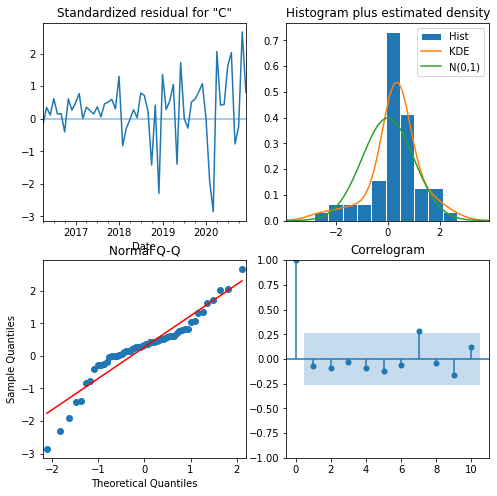

In [ ]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(sample,
                                        order=(2,1,1),
                                        seasonal_order=(1, 0, 1, 12),
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)

output = ARIMA_MODEL.fit()
print(output.summary().tables[1])

output.plot_diagnostics(figsize=(8, 8))
plt.show()
                                        

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=908.082, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1340.040, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=906.973, Time=0.47 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1016.768, Time=0.22 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=904.984, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1089.047, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 1.389 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   72
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -449.492
Date:                Thu, 24 Mar 2022   AIC                            904.984
Time:                        15:42:20   BIC      

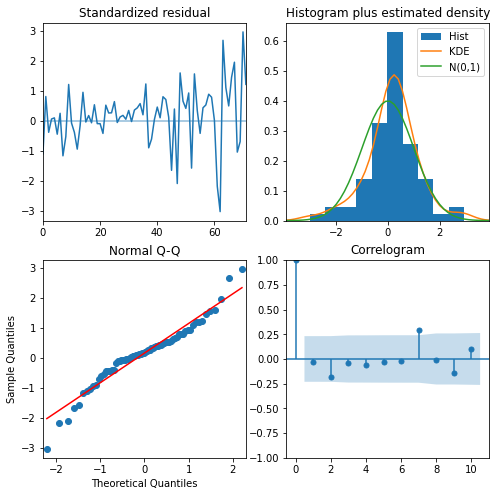

In [20]:
model = pm.auto_arima(sample, start_p=1, start_q=1,
                      test='adf',
                      max_p=1, max_q=1,
                      m=1,
                      d=0,
                      seasonal=True,
                      start_P=0, start_Q=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True, with_intercept=False)

print(model.summary())
model.plot_diagnostics(figsize=(8, 8))
plt.show()